# Our Goal

Our model is designed to compute:

$x_{t+1}$ from $x_t$

So we can directly predict the next state of our system given the current state.

# Our data

Our model receives:
- $x_t$: Current state
- Physical parameters: cell dimensions, cell area, distance between cells, flow velocity, diffusivity, atmospheric forcing.

And attempts to predict:
- $x_{t+1}$: The next state

We generate our data by:
- Generating a new, random world
- Run it forward one timestep to get both $x_t$ and $x_{t+1}$
- Using this pair to create one datapoint
- Repeat

# Imports

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import Dict, Tuple, List
import helper
import matplotlib.pyplot as plt
import os
import h5py
from tqdm import tqdm

# Class for generating data

In [ ]:
class StateModelDataset(Dataset):
    def __init__(self, num_samples: int, nr: int, nc: int, dt: float, F: float):
        self.num_samples = num_samples
        self.nr = nr
        self.nc = nc
        self.dt = dt
        self.F = F
        self.samples = self._generate_samples()

    def _generate_gaussian_field(self, n, nrv, ncv):
        """
        Generate a Gaussian field composed of n Gaussian functions.
        """
        mux = np.random.choice(ncv, n)
        muy = np.random.choice(range(2, nrv - 2), n)
        sigmax = np.random.uniform(1, ncv/4, n)
        sigmay = np.random.uniform(1, nrv/4, n)

        v = np.zeros((nrv, ncv))
        for i in range(n):
            for x in range(ncv):
                for y in range(nrv):
                    # Create three copies for pseudo-periodic field
                    gauss = np.exp(-((x-mux[i])**2/(2*sigmax[i]**2) + (y-muy[i])**2/(2*sigmay[i]**2)))
                    gauss += np.exp(-((x-(mux[i]-ncv))**2/(2*sigmax[i]**2) + (y-muy[i])**2/(2*sigmay[i]**2)))
                    gauss += np.exp(-((x-(mux[i]+ncv))**2/(2*sigmax[i]**2) + (y-muy[i])**2/(2*sigmay[i]**2)))
                    v[y,x] += gauss
        return v

    def _generate_circular_field(self, v):
        """
        Generate a circular field from gradient of input field.
        """
        grad_v_y, grad_v_x = np.gradient(v)
        return -grad_v_y, grad_v_x

    def _generate_params(self):
        """
        Generate model parameters similar to generate_world function.
        """
        # Base grid parameters
        DX_C = torch.ones(self.nr, self.nc + 1)
        DY_C = torch.ones(self.nr + 1, self.nc)
        DX_G = torch.ones(self.nr + 1, self.nc)
        DY_G = torch.ones(self.nr, self.nc + 1)
        RAC = torch.ones(self.nr, self.nc)

        # Generate random diffusivities (must be positive)
        KX = torch.abs(torch.rand(self.nr, self.nc + 1))
        KY = torch.abs(torch.rand(self.nr + 1, self.nc))

        # Generate velocities using Gaussian field approach
        num_gauss = 16  # Number of Gaussian functions for velocity field
        gauss = self._generate_gaussian_field(num_gauss, self.nr + 1, self.nc + 1)
        VX_np, VY_np = self._generate_circular_field(gauss)
        
        # Convert velocities to PyTorch and scale
        VX = torch.from_numpy(100 * VX_np[:-1, :]).float()
        VY = torch.from_numpy(100 * VY_np[:, :-1]).float()

        # Create random forcing term
        f = torch.randn(self.nr * self.nc)

        return {
            'KX': KX,
            'KY': KY,
            'DX_C': DX_C,
            'DY_C': DY_C,
            'DX_G': DX_G,
            'DY_G': DY_G,
            'VX': VX,
            'VY': VY,
            'RAC': RAC,
            'f': f,
        }

    def _compute_next_state(self, params, x_t):
        """
        Compute x(t+1) for the linear model.
        """
        # Convert PyTorch tensors to numpy arrays for helper function
        np_params = {
            key: tensor.cpu().detach().numpy() if torch.is_tensor(tensor) else tensor
            for key, tensor in params.items()
        }
        
        # Get model matrix M using helper function
        M = helper.make_M_2d_diffusion_advection_forcing(
            nr=self.nr,
            nc=self.nc,
            dt=self.dt,
            KX=np_params['KX'],
            KY=np_params['KY'],
            DX_C=np_params['DX_C'],
            DY_C=np_params['DY_C'], 
            DX_G=np_params['DX_G'],
            DY_G=np_params['DY_G'],
            VX=np_params['VX'],
            VY=np_params['VY'],
            RAC=np_params['RAC'],
            F=self.F,
            cyclic_east_west=True,
            cyclic_north_south=False,
            M_is_sparse=False
        )
        
        # Convert to numpy arrays and do matrix multiplication
        x_t_np = x_t.cpu().detach().numpy()
        f_np = np_params['f']
        
        # Compute next state: x(t+1) = Mx(t) + Ff
        result_np = M @ x_t_np + self.F * f_np
        
        # Convert back to PyTorch tensor
        return torch.from_numpy(result_np).float()

    def _generate_samples(self) -> list:
        """
        Generate multiple samples with parameters.
        """
        samples = []
        for _ in range(self.num_samples):
            params = self._generate_params()
            
            x_t = torch.randn(self.nr * self.nc)  # Current state
            x_t_plus_1 = self._compute_next_state(params, x_t)  # Next state
            
            samples.append((params, x_t, x_t_plus_1))
        
        return samples

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int):
        return self.samples[idx]

# Class for Model

In [ ]:
class StateModelNet(torch.nn.Module):
    def __init__(self, nr: int, nc: int):
        super().__init__()
        self.nr = nr
        self.nc = nc
        
        self.state_size = nr * nc
        self.param_size = (nr * (nc + 1) +        # KX
                         (nr + 1) * nc +          # KY
                         nr * (nc + 1) +          # DX_C
                         (nr + 1) * nc +          # DY_C
                         (nr + 1) * nc +          # DX_G
                         nr * (nc + 1) +          # DY_G
                         nr * (nc + 1) +          # VX
                         (nr + 1) * nc +          # VY
                         nr * nc +                # RAC
                         nr * nc)                 # f
        
        self.input_size = self.state_size + self.param_size
        self.output_size = self.state_size
        
        print(f"Input size: {self.input_size}")
        
        # Simplified architecture matching original size
        self.fc1 = torch.nn.Linear(self.input_size, 512)
        self.fc2 = torch.nn.Linear(512, self.output_size)
        self.activation = torch.nn.ReLU()
        
    def forward(self, x: torch.Tensor, params: Dict[str, torch.Tensor]) -> torch.Tensor:
        batch_size = x.size(0)
        
        # Ensure x has correct shape
        x = x.view(batch_size, -1)
        
        # Flatten the params dictionary into a single vector
        params_flat = torch.cat([param.view(batch_size, -1) for param in params.values()], dim=1)
        
        # Concatenate current state and parameters
        x = torch.cat([x, params_flat], dim=1)
        
        # Simple forward pass
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        
        return x


def train_model(model: torch.nn.Module, dataloader: DataLoader, num_epochs: int, learning_rate: float):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for params, x_t, x_next in dataloader:
            optimizer.zero_grad()
            output = model(x_t, params)
            loss = criterion(output, x_next)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}")

# Code to generate/load dataset

In [ ]:
def generate_and_save_dataset(
    filename: str,
    num_train_samples: int,
    num_test_samples: int,
    nr: int,
    nc: int,
    dt: float,
    F: float
) -> None:
    """
    Generate training and testing datasets and save them to an HDF5 file.
    
    Args:
        filename: Name of the file to save the data to
        num_train_samples: Number of training samples to generate
        num_test_samples: Number of testing samples to generate
        nr, nc: Grid dimensions
        dt: Time step
        F: Forcing parameter
    """
    # Create dataset instances
    train_dataset = StateModelDataset(num_train_samples, nr, nc, dt, F)
    test_dataset = StateModelDataset(num_test_samples, nr, nc, dt, F)
    
    with h5py.File(filename, 'w') as f:
        # Create train and test groups
        train_group = f.create_group('train')
        test_group = f.create_group('test')
        
        # Save metadata
        f.attrs['nr'] = nr
        f.attrs['nc'] = nc
        f.attrs['dt'] = dt
        f.attrs['F'] = F
        
        # Helper function to save a single dataset
        def save_dataset(group, dataset, desc):
            for i, (params, x_t, x_t_plus_1) in enumerate(tqdm(dataset, desc=desc)):
                sample_group = group.create_group(f'sample_{i}')
                
                # Save parameters
                params_group = sample_group.create_group('params')
                for key, value in params.items():
                    params_group.create_dataset(key, data=value.numpy())
                
                # Save states
                sample_group.create_dataset('x_t', data=x_t.numpy())
                sample_group.create_dataset('x_t_plus_1', data=x_t_plus_1.numpy())
        
        # Save training and testing datasets
        save_dataset(train_group, train_dataset, "Saving training data")
        save_dataset(test_group, test_dataset, "Saving testing data")

def load_dataset(filename: str) -> Tuple[Dict, Dict]:
    """
    Load training and testing datasets from an HDF5 file.
    
    Args:
        filename: Name of the file to load the data from
        
    Returns:
        Tuple of dictionaries containing training and testing data
    """
    train_data = []
    test_data = []
    
    with h5py.File(filename, 'r') as f:
        # Load metadata
        metadata = {
            'nr': f.attrs['nr'],
            'nc': f.attrs['nc'],
            'dt': f.attrs['dt'],
            'F': f.attrs['F']
        }
        
        # Helper function to load a single dataset
        def load_dataset(group):
            data = []
            for sample_name in tqdm(group.keys(), desc=f"Loading {group.name} data"):
                sample = group[sample_name]
                
                # Load parameters
                params = {
                    key: torch.from_numpy(value[:]).float()
                    for key, value in sample['params'].items()
                }
                
                # Load states
                x_t = torch.from_numpy(sample['x_t'][:]).float()
                x_t_plus_1 = torch.from_numpy(sample['x_t_plus_1'][:]).float()
                
                data.append((params, x_t, x_t_plus_1))
            return data
        
        # Load training and testing datasets
        train_data = load_dataset(f['train'])
        test_data = load_dataset(f['test'])
    
    return {
        'train': train_data,
        'metadata': metadata
    }, {
        'test': test_data,
        'metadata': metadata
    }

class SavedDataset(torch.utils.data.Dataset):
    """Dataset class for loading pre-saved data"""
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

def create_dataloaders(train_data, test_data, batch_size=32, shuffle_train=True):
    """
    Create DataLoader objects for training and testing datasets.
    
    Args:
        train_data: Training dataset
        test_data: Testing dataset
        batch_size: Batch size for DataLoaders
        shuffle_train: Whether to shuffle training data
        
    Returns:
        train_loader, test_loader: DataLoader objects
    """
    train_dataset = SavedDataset(train_data['train'])
    test_dataset = SavedDataset(test_data['test'])
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=shuffle_train,
        num_workers=0,  # Adjust based on system
        pin_memory=True  # Helps with GPU transfer
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0,  # Adjust based on system
        pin_memory=True  # Helps with GPU transfer
    )
    
    return train_loader, test_loader

In [ ]:
"""
generate_and_save_dataset(
    filename='state_model_data.h5',
    num_train_samples=10000,
    num_test_samples=1000,
    nr=10,
    nc=10,
    dt=0.1,
    F=1.0
)

# Load dataset and create dataloaders
train_data, test_data = load_dataset('state_model_data.h5')
train_loader, test_loader = create_dataloaders(
    train_data, 
    test_data, 
    batch_size=32
)
"""

# Training and Evaluating the Model

In [ ]:
def train_and_evaluate_model(
    model: torch.nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    num_epochs: int,
    learning_rate: float,
    device: str = 'cpu',
    run_number: int = None
):
    """
    Train and evaluate a single model instance.
    """
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()
    
    # Lists to store losses for plotting
    train_losses = []
    test_losses = []
    
    run_str = f" (Run {run_number})" if run_number is not None else ""
    print(f"Training started{run_str}...")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for params, x_t, x_t_plus_1 in train_dataloader:
            x_t = x_t.to(device)
            x_t_plus_1 = x_t_plus_1.to(device)
            params = {k: v.to(device) for k, v in params.items()}
            
            optimizer.zero_grad()
            predicted = model(x_t, params)
            loss = criterion(predicted, x_t_plus_1)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        # Evaluation phase
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for params, x_t, x_t_plus_1 in test_dataloader:
                x_t = x_t.to(device)
                x_t_plus_1 = x_t_plus_1.to(device)
                params = {k: v.to(device) for k, v in params.items()}
                
                predicted = model(x_t, params)
                test_loss = criterion(predicted, x_t_plus_1)
                total_test_loss += test_loss.item()
        
        # Calculate average losses
        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_test_loss = total_test_loss / len(test_dataloader)
        
        # Store losses for plotting
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        if (epoch + 1) % 10 == 0:  # Print every 10 epochs
            print(f"Run {run_number}, Epoch {epoch+1}/{num_epochs}")
            print(f"Training Loss: {avg_train_loss:.6f}")
            print(f"Test Loss: {avg_test_loss:.6f}")
    
    print(f"Training complete{run_str}!")
    return model, train_losses, test_losses

def train_multiple_models(
    nr: int, 
    nc: int, 
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    num_runs: int = 10,
    num_epochs: int = 50,
    learning_rate: float = 0.001,
    device: str = 'cpu'
):
    """
    Train multiple models and analyze their performance.
    """
    all_models = []
    all_train_losses = []
    all_test_losses = []
    
    for i in range(num_runs):
        print(f"\nStarting model {i+1}/{num_runs}")
        model = StateModelNet(nr, nc)
        
        trained_model, train_losses, test_losses = train_and_evaluate_model(
            model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            num_epochs=num_epochs,
            learning_rate=learning_rate,
            device=device,
            run_number=i+1
        )
        
        # Plot individual run results
        plt.figure(figsize=(10, 6))
        epochs = range(1, num_epochs + 1)
        plt.plot(epochs, train_losses, 'b-', label='Training Loss')
        plt.plot(epochs, test_losses, 'r-', label='Test Loss')
        plt.title(f'Training and Testing Loss Over Time - Run {i+1}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        all_models.append(trained_model)
        all_train_losses.append(train_losses)
        all_test_losses.append(test_losses)
    
    return all_models, all_train_losses, all_test_losses


Run 1, Epoch 20/50
Training Loss: 215.582416
Test Loss: 216.372199
Run 1, Epoch 30/50
Training Loss: 215.380158
Test Loss: 216.329350
Run 1, Epoch 40/50
Training Loss: 214.735026
Test Loss: 215.126020
Run 1, Epoch 50/50
Training Loss: 211.918173
Test Loss: 212.770759
Training complete (Run 1)!


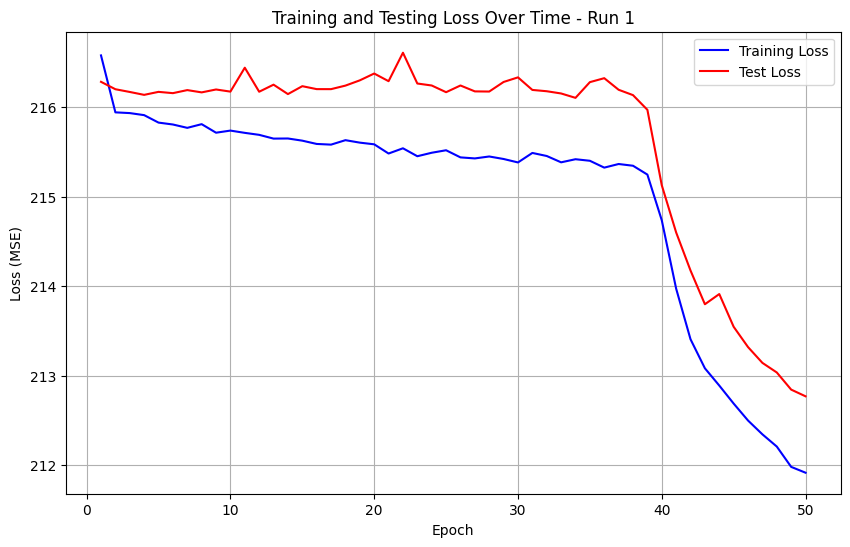


Starting model 2/10
Input size: 1180
Training started (Run 2)...
Run 2, Epoch 10/50
Training Loss: 215.778276
Test Loss: 216.183128
Run 2, Epoch 20/50
Training Loss: 215.663643
Test Loss: 216.207819
Run 2, Epoch 30/50
Training Loss: 215.546592
Test Loss: 216.337075
Run 2, Epoch 40/50
Training Loss: 215.406117
Test Loss: 216.458708
Run 2, Epoch 50/50
Training Loss: 215.263626
Test Loss: 216.308549
Training complete (Run 2)!


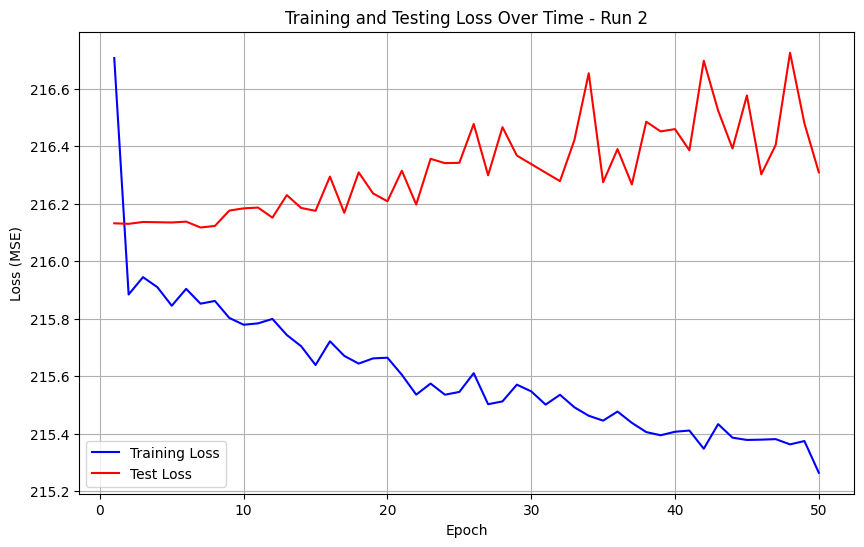


Starting model 3/10
Input size: 1180
Training started (Run 3)...
Run 3, Epoch 10/50
Training Loss: 215.737752
Test Loss: 216.257367
Run 3, Epoch 20/50
Training Loss: 215.470186
Test Loss: 216.225615
Run 3, Epoch 30/50
Training Loss: 215.337769
Test Loss: 216.479468
Run 3, Epoch 40/50
Training Loss: 215.254886
Test Loss: 216.483150
Run 3, Epoch 50/50
Training Loss: 215.114787
Test Loss: 216.568791
Training complete (Run 3)!


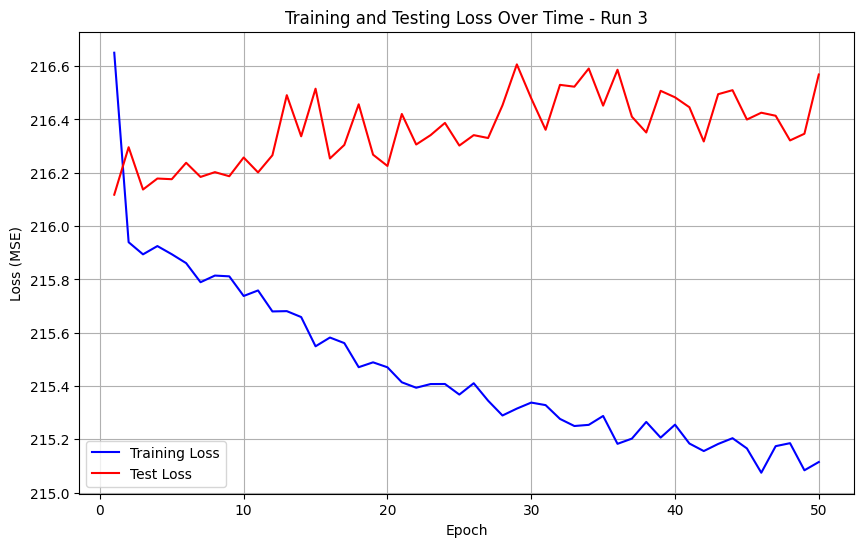


Starting model 4/10
Input size: 1180
Training started (Run 4)...
Run 4, Epoch 10/50
Training Loss: 215.751927
Test Loss: 216.162374
Run 4, Epoch 20/50
Training Loss: 215.694447
Test Loss: 216.222576
Run 4, Epoch 30/50
Training Loss: 215.609370
Test Loss: 216.243632
Run 4, Epoch 40/50
Training Loss: 215.563558
Test Loss: 216.517472
Run 4, Epoch 50/50
Training Loss: 215.496414
Test Loss: 216.137693
Training complete (Run 4)!


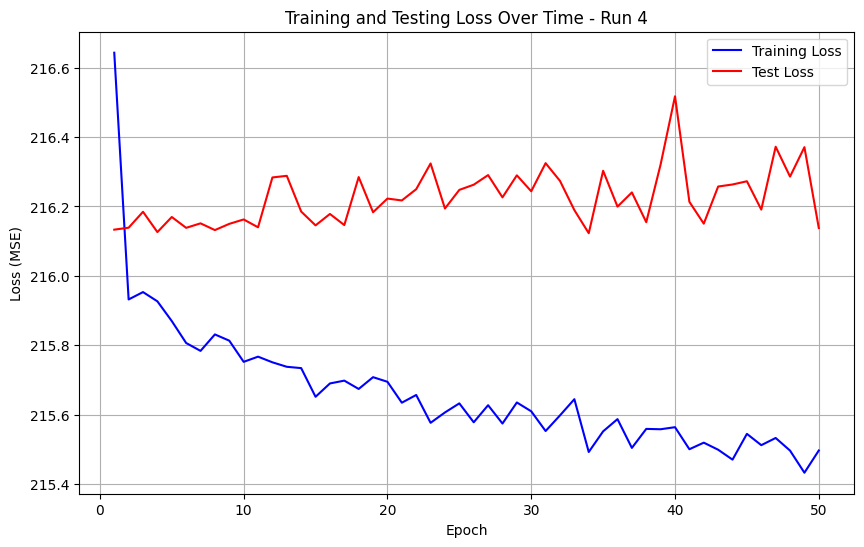


Starting model 5/10
Input size: 1180
Training started (Run 5)...
Run 5, Epoch 10/50
Training Loss: 215.706063
Test Loss: 216.197990
Run 5, Epoch 20/50
Training Loss: 215.512674
Test Loss: 216.321841
Run 5, Epoch 30/50
Training Loss: 215.490132
Test Loss: 216.237894
Run 5, Epoch 40/50
Training Loss: 215.460725
Test Loss: 216.411357
Run 5, Epoch 50/50
Training Loss: 215.356158
Test Loss: 216.243166
Training complete (Run 5)!


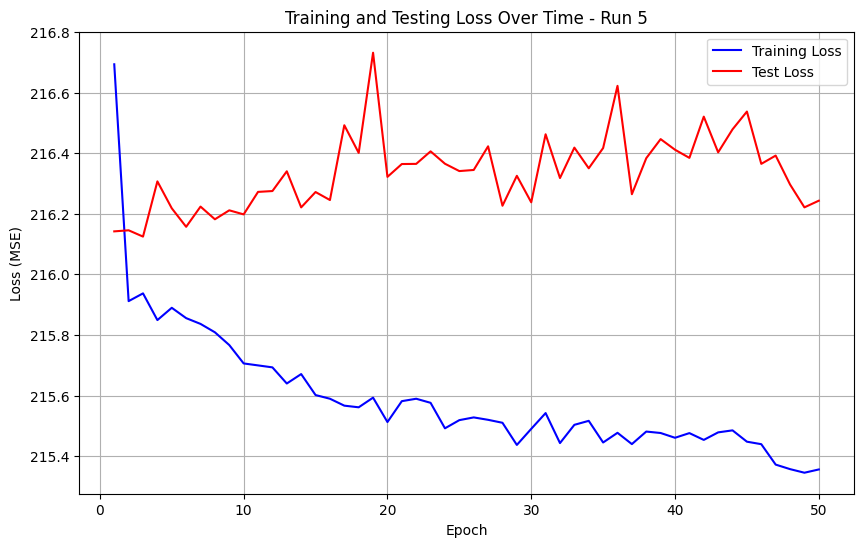


Starting model 6/10
Input size: 1180
Training started (Run 6)...
Run 6, Epoch 10/50
Training Loss: 215.764653
Test Loss: 216.148285
Run 6, Epoch 20/50
Training Loss: 215.577890
Test Loss: 216.368910
Run 6, Epoch 30/50
Training Loss: 215.419810
Test Loss: 216.338291
Run 6, Epoch 40/50
Training Loss: 215.307085
Test Loss: 216.519834
Run 6, Epoch 50/50
Training Loss: 215.205017
Test Loss: 216.421935
Training complete (Run 6)!


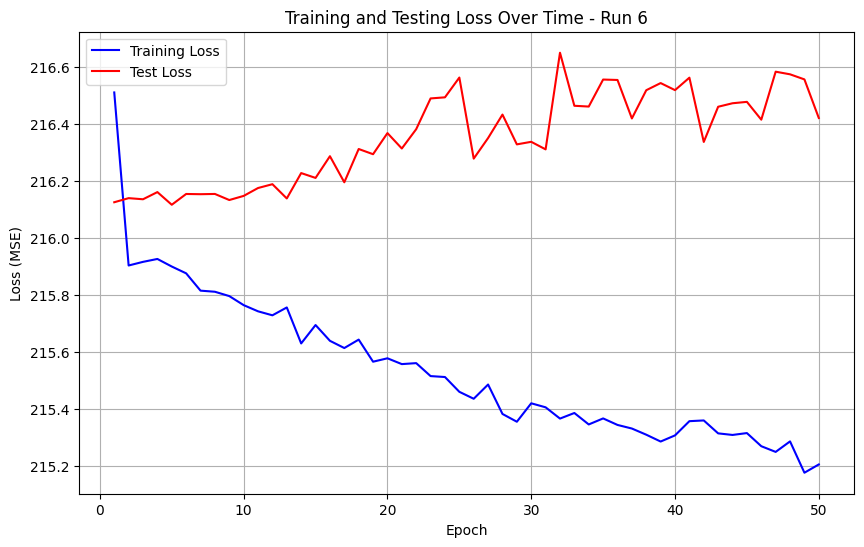


Starting model 7/10
Input size: 1180
Training started (Run 7)...


KeyboardInterrupt: 

In [30]:
train_data, test_data = load_dataset('state_model_data.h5')
train_loader = DataLoader(SavedDataset(train_data['train']), batch_size=32, shuffle=True)
test_loader = DataLoader(SavedDataset(test_data['test']), batch_size=32, shuffle=False)

# Train multiple models
device = 'cuda' if torch.cuda.is_available() else 'cpu'
models, train_losses, test_losses = train_multiple_models(
    nr=10, 
    nc=10, 
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    num_runs=10,
    num_epochs=50,
    device=device)